<a href="https://colab.research.google.com/github/Shivakumarsullagaddi/CCBD_MRI/blob/main/notebook9b146e79af.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification
#3D RESNET for MRI Classification in PyTorch

0 → CN (Not Alzheimer's)

1 → AD (Alzheimer's)

**Output**

Val acc : ~75%

ROC AUC: 0.847


**Solved Problems**

>solved the problem of dataset,Now we have 650 subjects in each class



**Problem :**
            

> model is little overfitting

> Try with different models,next aim DenseNet

**learning**
<br>3D images needs more compution (GPUs) TAKES MORE TIME WITH CPU

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

shivakumarullagaddi_dataset_nifiti2_path = kagglehub.dataset_download('shivakumarullagaddi/dataset-nifiti2')

print('Data source import complete.')


In [ ]:
!pip install nibabel scipy

import os
import random
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models.video import r3d_18, R3D_18_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
from scipy.ndimage import zoom

from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


 Data Augmentation Function

In [ ]:
def augment_volume(volume):
    if random.random() > 0.5:
        volume = np.flip(volume, axis=0)
    if random.random() > 0.5:
        volume = np.flip(volume, axis=1)
    if random.random() > 0.5:
        volume = np.flip(volume, axis=2)
    k = random.choice([0,1,2,3])
    axis = random.choice([(0,1),(1,2),(0,2)])
    volume = np.rot90(volume, k=k, axes=axis)
    noise = np.random.normal(0, 0.01, volume.shape)
    volume = volume + noise
    volume = np.clip(volume, 0, 1)
    return volume


3. CBAM Modules for 3D

In [ ]:
class ChannelAttention3D(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.max_pool = nn.AdaptiveMaxPool3d(1)
        self.fc = nn.Sequential(
            nn.Conv3d(in_planes, in_planes // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv3d(in_planes // reduction, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention3D(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv3d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAM3D(nn.Module):
    def __init__(self, in_planes, reduction=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention3D(in_planes, reduction)
        self.sa = SpatialAttention3D(kernel_size)
    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x


4. MRI3DDataset with Augmentation

In [ ]:
class MRI3DDataset(Dataset):
    def __init__(self, samples, target_shape=(128, 128, 128), augment=False):
        self.samples = samples
        self.target_shape = target_shape
        self.augment = augment
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        nii_path, label = self.samples[idx]
        img = nib.load(nii_path).get_fdata()
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = self.resize_volume(img, self.target_shape)
        if self.augment:
            img = augment_volume(img)
        img = img[np.newaxis, ...].astype(np.float32)
        return torch.tensor(img), label
    def resize_volume(self, volume, target_shape):
        depth, height, width = volume.shape
        target_depth, target_height, target_width = target_shape
        depth_factor = target_depth / depth
        height_factor = target_height / height
        width_factor = target_width / width
        return zoom(volume, (depth_factor, height_factor, width_factor), order=1)


5. Data Preparation

In [ ]:
root_dir = '/kaggle/input/dataset-nifiti2/DATASET_NIFTI2'
class_names = ['AD', 'CN']
class_map = {'CN': 0, 'AD': 1}
random.seed(42)

# Define the lists before using them!
train_samples, val_samples, test_samples = [], [], []

for cls in class_names:
    class_dir = os.path.join(root_dir, cls)
    nii_files = [f for f in os.listdir(class_dir) if f.endswith(('.nii', '.nii.gz'))]
    random.shuffle(nii_files)
    n_total = len(nii_files)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val
    for file_list, sample_list in zip([nii_files[:n_train],
                                       nii_files[n_train:n_train+n_val],
                                       nii_files[n_train+n_val:]],
                                      [train_samples, val_samples, test_samples]):
        for nii_file in file_list:
            nii_path = os.path.join(class_dir, nii_file)
            sample_list.append((nii_path, class_map[cls]))


6. Data Loaders (Batch Size 4 or 8, Augmentation for Training)

In [ ]:
batch_size = 4  # or 8, depending on GPU RAM
target_shape = (128, 128, 128)
train_dataset = MRI3DDataset(train_samples, target_shape, augment=True)
val_dataset = MRI3DDataset(val_samples, target_shape, augment=False)
test_dataset = MRI3DDataset(test_samples, target_shape, augment=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


7. 3D-ResNet + CBAM Model with Transfer Learning and Dropout

In [ ]:
class ResNet3D_CBAM_TL(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        self.model = r3d_18(weights=R3D_18_Weights.DEFAULT if pretrained else None)
        self.model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7),
                                        stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.model.fc = nn.Identity()  # Remove final FC for custom head
        self.cbam1 = CBAM3D(64)
        self.cbam2 = CBAM3D(64)
        self.cbam3 = CBAM3D(128)
        self.cbam4 = CBAM3D(256)
        self.cbam5 = CBAM3D(512)
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.model.stem(x)
        x = self.cbam1(x)
        x = self.model.layer1(x)
        x = self.cbam2(x)
        x = self.model.layer2(x)
        x = self.cbam3(x)
        x = self.model.layer3(x)
        x = self.cbam4(x)
        x = self.model.layer4(x)
        x = self.cbam5(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

model = ResNet3D_CBAM_TL(pretrained=True).to(device)


Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:02<00:00, 58.8MB/s] 


8. Training Loop (Mixed Precision, 50 Epochs)

In [ ]:
from torch.amp import autocast, GradScaler

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scaler = GradScaler('cuda')
num_epochs = 10
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for volumes, labels in train_loader:
        volumes, labels = volumes.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(volumes)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * volumes.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for volumes, labels in val_loader:
            volumes, labels = volumes.to(device), labels.to(device)
            with autocast('cuda'):
                outputs = model(volumes)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

    print(f"Epoch {epoch+1}/{num_epochs}: Loss={running_loss/len(train_loader.dataset):.4f} "
          f"Train Acc={train_acc:.2f}% Val Acc={val_acc:.2f}%")


Epoch 1/10: Loss=0.6715 Train Acc=58.48% Val Acc=52.06%
Epoch 2/10: Loss=0.6420 Train Acc=64.10% Val Acc=56.19%
Epoch 3/10: Loss=0.6364 Train Acc=64.21% Val Acc=52.06%
Epoch 4/10: Loss=0.6234 Train Acc=66.96% Val Acc=65.46%
Epoch 5/10: Loss=0.6184 Train Acc=67.18% Val Acc=50.52%
Epoch 6/10: Loss=0.6203 Train Acc=66.30% Val Acc=70.62%
Epoch 7/10: Loss=0.6119 Train Acc=67.40% Val Acc=53.61%
Epoch 8/10: Loss=0.6017 Train Acc=68.94% Val Acc=56.70%
Epoch 9/10: Loss=0.5965 Train Acc=70.26% Val Acc=77.84%
Epoch 10/10: Loss=0.5952 Train Acc=68.83% Val Acc=61.34%


9. Evaluation and Visualization

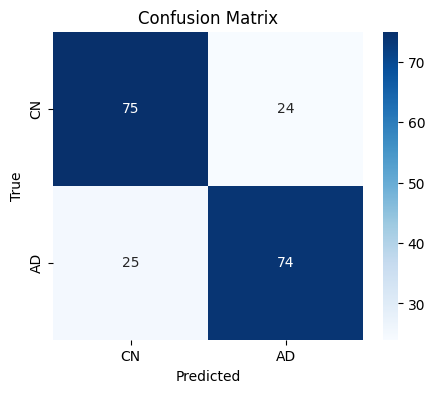

              precision    recall  f1-score   support

          CN       0.75      0.76      0.75        99
          AD       0.76      0.75      0.75        99

    accuracy                           0.75       198
   macro avg       0.75      0.75      0.75       198
weighted avg       0.75      0.75      0.75       198



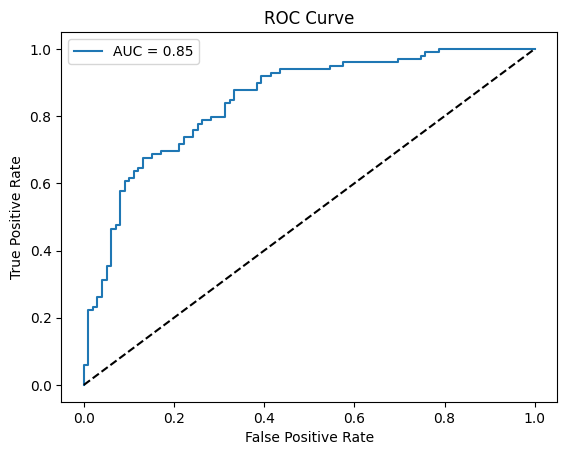

ROC AUC: 0.847


In [ ]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()
all_preds, all_targets, all_probs = [], [], []
with torch.no_grad():
    for volumes, labels in test_loader:
        volumes = volumes.to(device)
        outputs = model(volumes)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["CN", "AD"],
            yticklabels=["CN", "AD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_targets, all_preds, target_names=["CN", "AD"]))

auc = roc_auc_score(all_targets, all_probs)
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print(f"ROC AUC: {auc:.3f}")
